The goal of this notebook is to illustrate the possibilities of the tesserae package in combination with various bioinformatics tools in identifying intertextual references in Maximus the Confessors's _Quaestiones ad Thalassium_. 

In [13]:
import json
from bson import ObjectId
import pandas as pd

from tesserae.db import TessMongoConnection
from tesserae.db.entities import Match, Text, Token, Unit, Vector
from tesserae.utils import TessFile
from tesserae.tokenizers import GreekTokenizer, LatinTokenizer
from tesserae.unitizer import Unitizer
from tesserae.matchers.sparse_encoding import SparseMatrixSearch
from tesserae.utils.calculations import get_text_frequencies

connection = TessMongoConnection('127.0.0.1', 27017, None, None, db='tesstest')

# Reset and load texts

Format word documents

In [11]:
from docx import Document

folder = "/home/administrador/maximus-confessor/texts/maximus/"
document = Document(folder+"questions_doubts.docx")
titles = []
f = open('test.tess','w')
for paragraph in document.paragraphs:
    if paragraph.style.name == "Heading 3":
        f.close()
        f = open(folder+'maximus_confessor.'+paragraph.text+'.tess','w')
        titles.append(paragraph.text)
        title = titles[-1][:2]
        part = 0
        line = 0
    elif paragraph.style.name == "Heading 4":
        part += 1
        line = 0
    elif paragraph.style.name == "Normal":
        if len(paragraph.text)>1:
            line +=1
        #if part == 1:
    #    part_name = 'prol'
    #    elif part > 1:
    #        part_name = part-1
        part_name = part
        if part != 0 and len(paragraph.text)>1:
            f.write('<'+title+' '+str(part_name)+'.'+str(line)+'> '+paragraph.text+'\n')
        elif part == 0:
            f.write('<'+title+' '+str(line)+'> '+paragraph.text+'\n')
    else:
        print(paragraph.style.name)
f.close()

Load texts

In [14]:
#connection.connection['features'].delete_many({})
#connection.connection['frequencies'].delete_many({})
##connection.connection['matches'].delete_many({})
#connection.connection['texts'].delete_many({})
#connection.connection['tokens'].delete_many({})
#connection.connection['units'].delete_many({})
#connection.connection['translations'].delete_many({})

with open('data/maximus_texts.json', 'r') as f:
    text_meta = json.load(f)

texts = []
for t in text_meta:
    texts.append(Text.json_decode(t))
result = connection.insert(texts)
print('Inserted {} texts.'.format(len(result.inserted_ids)))

for text in texts:
    tessfile = TessFile(text.path, metadata=text)

    tokenizer = GreekTokenizer(connection)
    tokens, tags, features = tokenizer.tokenize(tessfile.read(), text=tessfile.metadata)    
    result = connection.insert(features)
    result = connection.update(features)

    unitizer = Unitizer()
    lines, phrases = unitizer.unitize(tokens, tags, tessfile.metadata)
    result = connection.insert(lines + phrases)    

    result = connection.insert(tokens)
    
    print(text.title)

Inserted 15 texts.
Liber asceticus
Capita de caritate
Expositio in Psalmum LIX
Capita theologica et oeconomica
Mystagogia
Quaestiones ad Theopemptum
Epistulae
Opuscula
To Anastasius the Monk
Disputatio cum Pyrrho
Capita XV
Ambigua ad Thomam
Ambigua ad Iohannem
Quaestiones et dubia


More texts to load:
- all of Plato's dialogues are already available in the tesserae collection
- Aristotle is more limited, and there is nothing of Plotinus, Porphyry or Proclus -- can get these from Perseus

Main problems right now:
- Scholia of Pseudo-Dionysius will be difficult to format correctly, and are not yet loaded
- Opuscula have different numbering than PG
- I made a few mistakes, resulting in extra database entries; I removed the author from these and changed the title to "defective" to avoid confusion

# Linear Algebra Projections

Load frequencies. 

In [104]:
result = connection.aggregate('features',[ {'$match': { 'feature': 'lemmata' }}, 
                                          { "$project": {"data": { "$objectToArray": "$frequencies" }}},
                                          {'$unwind': '$data'},
                                          {'$project' : {
                                                '_id':1,
                                                'text' : '$data.k',
                                                'freq' : '$data.v' }}],
                     encode=False)
freqs = pd.DataFrame.from_dict(list(result)).pivot_table(values='freq',index=['_id'],columns=['text'],fill_value=0)

Load the labels. (lemma labels are slow -- should implement directly in mongodb query)

In [105]:
#lemma_labels=[]
#for idx in freqs.index:
#    lemma_labels.append(connection.find('features',_id=idx)[0].token)
#freqs.index = lemma_labels

text_labels=[]
for t in freqs.keys():
    text_labels.append(connection.find('texts',_id=ObjectId(t))[0].title)
freqs.columns = text_labels

Make projections

In [107]:
import scripts.lap_v2_py3 as lap_v2
import numpy as np

names = ['ΠΡΟΣ ΘΑΛΑΣΣΙΟΝ']

freqs_norm = freqs.copy()
N = np.shape(freqs)[0]
for item in freqs:
    freqs_norm[item] = lap_v2.rank_norm(np.asarray(freqs[item]), dist='normal',norm=N)

data = freqs_norm[names]
basis = freqs_norm.T.drop(names).T

[a, A, eta] = lap_v2.lap(basis.values, data.values, full_output=True)

projections = pd.DataFrame(data = a, index = basis.keys(), columns = names)
eta = pd.DataFrame(data = eta.T, index = data.index, columns = basis.keys())

In [108]:
projections

,ΠΡΟΣ ΘΑΛΑΣΣΙΟΝ
New Testament,0.253213
Historia Ecclesiastica,0.075002
Metaphysics,0.197027


# Sequence Alignment

Get list of lemmas from unit

In [2]:
def get_lemma_seq(title,**kwargs):
    #possible kwargs: tags, index, unit_type
    text = connection.find('texts',title = title)[0].id
    kwargs['text'] = text
    result = connection.aggregate('units',[{'$match': kwargs}, 
                                       {"$project": {"_id": 0, "tokens.display": 1, "tokens.features.lemmata": 1}},
                                       {"$unwind": "$tokens"},
                                       {"$project": {"token": '$tokens.display', "lemma" : { "$arrayElemAt" : ["$tokens.features.lemmata", 0]}}}],
                                  encode=False)
    return pd.DataFrame.from_dict(result).set_index('token').squeeze()

A simple Smith-Waterman implementation, courtesy of ChatGPT. Extremely inefficient, could be sped up significantly.

In [3]:
def smith_waterman(seq1_ser, seq2_ser, match=2, mismatch=-1, gap_penalty=-1, traceback = True):
    seq1 = list(seq1_ser.values)
    seq2 = list(seq2_ser.values)
    idx1 = list(seq1_ser.keys())
    idx2 = list(seq2_ser.keys())
    
    # Create a matrix to store the scores for each position in the sequences
    rows, cols = len(seq1) + 1, len(seq2) + 1
    score_matrix = [[0 for _ in range(cols)] for _ in range(rows)]

    # Initialize the maximum score and its position
    max_score = 0
    max_i, max_j = 0, 0

    # Fill in the score matrix
    for i in range(1, rows):
        for j in range(1, cols):
            if seq1[i - 1] == seq2[j - 1]:
                match_score = score_matrix[i - 1][j - 1] + match
            else:
                match_score = score_matrix[i - 1][j - 1] + mismatch

            delete_score = score_matrix[i - 1][j] + gap_penalty
            insert_score = score_matrix[i][j - 1] + gap_penalty

            score_matrix[i][j] = max(0, match_score, delete_score, insert_score)

            if score_matrix[i][j] > max_score:
                max_score = score_matrix[i][j]
                max_i, max_j = i, j

    if traceback:
        # Traceback to find the aligned sequences
        aligned_seq1, aligned_seq2 = [], []
        i, j = max_i, max_j
    
        while score_matrix[i][j] > 0:
            if score_matrix[i][j] == score_matrix[i - 1][j - 1] + (match if seq1[i - 1] == seq2[j - 1] else mismatch):
                aligned_seq1.insert(0, idx1[i - 1])
                aligned_seq2.insert(0, idx2[j - 1])
                i -= 1
                j -= 1
            elif score_matrix[i][j] == score_matrix[i - 1][j] + gap_penalty:
                aligned_seq1.insert(0, idx1[i - 1])
                aligned_seq2.insert(0, "-")
                i -= 1
            else:
                aligned_seq1.insert(0, "-")
                aligned_seq2.insert(0, idx2[j - 1])
                j -= 1

        aligned_seq1 = ' '.join(aligned_seq1)
        aligned_seq2 = ' '.join(aligned_seq2)
        return aligned_seq1, aligned_seq2, max_score
    else:
        return max_score

# Example usage:
seq1 = get_lemma_seq('ΠΡΟΣ ΘΑΛΑΣΣΙΟΝ',tags='2.2',unit_type='phrase')
seq2 = get_lemma_seq('New Testament',tags='John.5.17',unit_type='phrase')
aligned_seq1, aligned_seq2, score = smith_waterman(seq1, seq2, match=2, mismatch=-1, gap_penalty=-1)
print("Aligned Sequence 1:", aligned_seq1)
print("Aligned Sequence 2:", aligned_seq2)
print("Alignment Score:", score)

Aligned Sequence 1: Πατήρ μου ἕως ἄρτι ἐργάζεται κἀγὼ ἐργάζομαι
Aligned Sequence 2: πατήρ μου ἕως ἄρτι ἐργάζεται κἀγὼ ἐργάζομαι
Alignment Score: 14


Basic strategy for searching for vocab overlap: 
1. Starting from lemma sequence function, unwind one more time to get list of lemma-tag pairs.
2. Use these pairs to build a binary sparse matrix, with 1 where a lemma exists within a tag and 0 otherwise.
3. Multiply these matrices to get the overlaps between units.

I've implemented this, but now I need to add the stoplist to avoid getting nonsense results. New to do list:
1. Implement query to return frequency counts for whole corpus, keeping display and index, to make stop list
2. Redo matrix multiplication: Save dimensions, then append second to first and square it. This allows generalization to arbitrary number of texts.
3. Extract values and indices from resulting matrix
4. Select from the array of indices based on score threshold and generate graph (using text title as node label)
5. Test plotting, coloring by node label

*The above list is all done now too.* Subsequent refinements:
1. Run sequence alignment on pairs over certain threshold, and re-threshold with alignment score
2. Add aligned texts to edge data, for easy lookup
3. Extract chapter number from tags and add this to the node data

In [4]:
n_stop = 100
result = connection.aggregate('features',[ {'$match': { 'feature': 'lemmata' }}, 
                                          { "$project": {"data": { "$objectToArray": "$frequencies" }}},
                                          {'$unwind': '$data'},
                                          {'$project' : {
                                                '_id':1,
                                                'text' : '$data.k',
                                                'freq' : '$data.v' }}],
                     encode=False)
freqs = pd.DataFrame.from_dict(list(result)).pivot_table(values='freq',index=['_id'],columns=['text'],fill_value=0)
stoplist = freqs.sum(axis=1).sort_values(ascending=False).iloc[:n_stop].values

In [5]:
from scipy.sparse import csr_array
import numpy as  np

def get_unit_lemma_matrix(title,unit_type='line',stoplist=[]):
    text = connection.find('texts',title = title)[0].id
    result = connection.aggregate('units',[{'$match': {'text': text, 'unit_type': unit_type}}, 
                                       {"$project": {"_id": 0, "index": 1, "tokens.features.lemmata": 1}},
                                       {"$unwind": "$tokens"},
                                       {"$project": {"index": 1, "lemmata" : { "$arrayElemAt" : ["$tokens.features.lemmata", 0]}}}],
                                  encode=False)
    sp = pd.DataFrame.from_dict(result) 
    sp = sp[~sp['lemmata'].isin(list(stoplist)+[-1])].values
    #sp = sp[np.where(np.min(sp,axis=1)>=0),:].squeeze()
    M = np.max(sp[:,0])+1
    N = np.max(pd.DataFrame.from_dict(connection.aggregate('features',[{'$match': {'feature': 'lemmata'}},{'$project': {'_id':0, 'index':1}}],encode=False)).squeeze().values)+1
    sp = csr_array((np.ones(len(sp)),(sp[:,0],sp[:,1])),shape=[M,N])
    sp.sum_duplicates()
    return sp.sign()

In [47]:
titles = ['ΠΡΟΣ ΘΑΛΑΣΣΙΟΝ','New Testament']
sp1 = get_unit_lemma_matrix(titles[0],stoplist=stoplist,unit_type='phrase')
sp2 = get_unit_lemma_matrix(titles[1],stoplist=stoplist,unit_type='phrase')

# Arc Diagram and Chord Diagram

Both of these can be easily constructed using networkx, based on a graph object (https://ericmjl.github.io/Network-Analysis-Made-Simple/01-introduction/03-viz/). 

In [48]:
import networkx as nx
import numpy as np
from scipy.sparse import issparse, vstack

def create_graph_from_entity_matrices(matrices, titles, n):
    # Concatenate matrices vertically
    concatenated_matrix = vstack(matrices, format='csr')

    # Calculate the overlap matrix by squaring the concatenated matrix
    overlap_matrix = concatenated_matrix.dot(concatenated_matrix.T)
    overlap_matrix.setdiag(0)

    # Binarize the overlap matrix based on the threshold n
    binarized_matrix = (overlap_matrix >= n).astype(int)

    # Create a graph from the binarized matrix
    G = nx.from_scipy_sparse_array(binarized_matrix)

    node_data = {}
    for k in range(len(matrices)):
        node_data.update({node_id: {'title': titles[k]} for node_id in range(len(node_data),len(node_data)+matrices[k].shape[0])})
    nx.set_node_attributes(G,node_data)
    
    return G

# Example usage:
# matrices is a list of sparse matrices
# n is the minimum number of nonzero features to create an edge
matrices = [sp1,sp2]  # Replace [...] with your list of sparse matrices
titles = ['ΠΡΟΣ ΘΑΛΑΣΣΙΟΝ','New Testament']
n = 4  # Replace 2 with your desired threshold

graph = create_graph_from_entity_matrices(matrices, titles, n)

# Now you can use the graph for various network analysis tasks with NetworkX


/home/administrador/virtual_env/py38/lib/python3.8/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


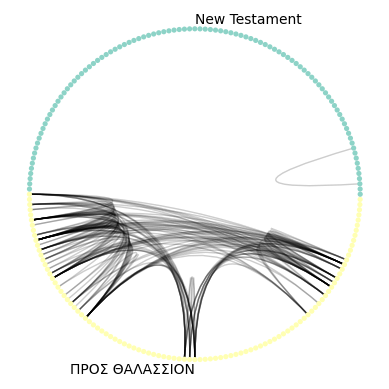

In [49]:
import nxviz as nv 
from nxviz import annotate

nv.circos(graph,group_by='title',node_color_by='title')
annotate.circos_group(graph, group_by="title")

I also discovered this library called "Bokeh," which can make the graphs interactive: https://docs.bokeh.org/en/latest/index.html

Next steps: 
1. Use MongoDB query to get list of all tags, (or maybe title-tag pairs), to use as the nodes
2. Use the results of the previous section to return a list of tuples of two title-tag pairs, indicating all alignments over a certain score threshold
3. Make arc and chord plots
4. Interactive: use Bokeh to display the alignment when you hover over an edge

# GPT Translations

The aim of this section to test the utility of OpenAI's GPT for accelerating the work of translating Greek partristic texts. First, I will run a brief test to confirm that the API works, then set up a script to translate unit by unit from the database and save in a new collection, and finally test the power of fine-tuning the model using translations that I have already proofread.

## Initialize the client

In [2]:
from openai import OpenAI

with open('api_key.txt','r') as f:
    api_key = f.read()
client = OpenAI(api_key=api_key)

## Test the API

In [2]:
response = client.chat.completions.create(
  model="gpt-3.5-turbo",
  messages=[
    {"role": "user", "content": "Say this is a test."}
  ]
)

In [14]:
response.choices[0].message.content

'This is a test.'

## Test Translation

First let's load the text I want to use for benchmarking, from Q60 of Ad Thalassium

In [19]:
thal = connection.find('texts',title='ΠΡΟΣ ΘΑΛΑΣΣΙΟΝ')[0].id
content = connection.find('units',tags='60.5',text=thal,unit_type='line')[0].snippet

In [20]:
content

'Ἔπρεπε γὰρ τῷ ποιητῇ τῶν ὅλων καὶ γινομένῳ φύσει κατ᾽ οἰκονομίαν ὅπερ οὐκ ἦν καὶ ἑαυτὸν ὅπερ ἦν κατὰ φύσιν καὶ ὅπερ γέγονε φύσει κατ᾽ οἰκονομίαν ἄτρεπτον διασώσασθαι. Θεῷ γὰρ οὐ πέφυκεν ἐνθεωρεῖσθαι τροπή, ᾧ μηδεμία καθάπαξ κίνησις ἐπινοεῖται, περὶ ἣν ὑπάρχει τοῖς κινουμένοις τὸ τρέπεσθαι. Τοῦτό ἐστι τὸ μέγα καὶ ἀπόκρυφον μυστήριον. Τοῦτό ἐστι τὸ μακάριον, δι᾽ ὃ τὰ πάντα συνέστησαν, τέλος. Τοῦτό ἐστιν ὁ τῆς ἀρχῆς τῶν ὄντων προεπινοούμενος θεῖος σκοπός, ὃν ὁρίζοντες εἶναί φαμεν προεπινοούμενον τέλος, οὗ ἕνεκα μὲν τὰ πάντα, αὐτὸ δὲ οὐδενὸς ἕνεκεν· πρὸς τοῦτο τὸ τέλος ἀφορῶν τὰς τῶν ὄντων ὁ Θεὸς παρήγαγεν οὐσίας. Τοῦτο κυρίως ἐστὶ τὸ τῆς προνοίας καὶ τῶν προνοουμένων πέρας, καθ᾽ ὃ εἰς τὸν Θεὸν ἡ τῶν ὑπ᾽ αὐτοῦ πεποιημένων ἐστὶν ἀνακεφαλαίωσις. Τοῦτό ἐστι τὸ πάντας περιγράφον τοὺς αἰῶνας καὶ τὴν ὑπεράπειρον καὶ ἀπειράκις ἀπείρως προϋπάρχουσαν τῶν αἰώνων μεγάλην τοῦ Θεοῦ βουλὴν ἐκφαῖνον μυστήριον, ἧς γέγονεν ἄγγελος αὐτὸς ὁ κατ᾽ οὐσίαν τοῦ Θεοῦ Λόγος, γενόμενος ἄνθρωπος καὶ αὐτόν, εἰ θέμις 

In [58]:
response = client.chat.completions.create(
  model="gpt-3.5-turbo",
  messages=[
    {"role": "system", "content": "You are a translator from Byzantine Greek to English."},
    {"role": "user", "content": content}
  ]
)

translation = response.choices[0].message.content

In [59]:
translation

"For it was fitting for the poet of all things and by his very nature becoming, by economy, that which he was not and himself, which he was according to nature, and that which became by nature, to remain unchanging. For it is not fitting for God to observe a change, to whom no movement is conceived, regarding which there is a turning for moving things. This is the great and hidden mystery. This is the blessed end for which all things were brought into existence. This is the divine purpose that preconceived the beginning of all things, which we declare to be the preconceived end, for the sake of which all things exist, but it exists for no other reason. For the purpose of this end, God brought forth the essences of beings. This is primarily the purpose of providence and the fulfillment of those who are provided for, through which the created beings clearly recapitulate into God. This is the knowledge that describes all ages and reveals the great, God's plan that transcends and is infini

Errors in first sentence:
1. poet --> maker
2. "becoming" --> "the one who became"
3. "and himself..." --> "both himself -- what he was according to nature"
4. "kat oikonomia" is missing
5. "to remain" --> "to preserve"

But in general it is pretty good. Probably worth using the free credits to translate as much as I can.

Compare with GPT-4:

In [12]:
response = client.chat.completions.create(
  model="gpt-4",
  messages=[
    {"role": "system", "content": "You are a translator from Byzantine Greek to English."},
    {"role": "user", "content": content}
  ]
)

response.choices[0].message.content

'For the poet of all, who is by nature also becoming, had to maintain unchanging both what he was not by economy and himself, what he was by nature and what he had become by economy. For it is not natural for God to undergo change, to whom no motion at all is conceived, about which the ability to change is inherent in the moving things. This is the great and hidden mystery. This is the blessed, for which everything was established, the end. This is the divine aim conceived before the existence of beings, which we define to be the conceived end, for the sake of which everything is, but itself is for the sake of nothing; God led substances towards this end. This is primarily the terminus of providence and the things that are provided for, through which there is a recapitulation in God of the things made by him. This is the mystery revealing the great counsel of God that precedes infinitely and endlessly all the ages, of which the Word of God, himself the angel by nature, has become the m

## Fine-tuned model

This is only possible on a paid plan. I have created the beginning of a JSON training file in the "data" subfolder of the Maximus folder.

## Bulk Translation

Delete old translation:

In [23]:
chapter = 58
for k in range(1,100):
    out = connection.connection['translations'].delete_many({'tags':str(chapter)+'.'+str(k)})

Make function to translate chapter

In [28]:
from tesserae.db.entities import Translation
from openai import OpenAI
import time

with open('api_key.txt','r') as f:
    api_key = f.read()

def translate_chapter(title,chapter,start=0):
    text_id = connection.find('texts',title=title)[0].id
    result = connection.find('units',unit_type='line',text=text_id)
    client = OpenAI(api_key=api_key)
    n = 0

    for item in result:
        if item.tags[0].split('.')[0] == chapter:
            if n >= start:
                response = client.chat.completions.create(
                    model="gpt-4-turbo-preview",
                    messages=[
                        {"role": "system", "content": "You are a translator from Byzantine Greek to English."},
                        {"role": "user", "content": item.snippet}
                    ]
                )
                
                trans = response.choices[0].message.content
                trans_entry = Translation(text=item.text,tags=item.tags,index=item.index,unit_type=item.unit_type,snippet=trans)
                res = connection.insert(trans_entry)
                #time.sleep(15) #Time delay to avoid exceeding rate limit
            n += 1
            print(n)
            

    return str(n)+' translations inserted.'

Execute the function:

In [29]:
translate_chapter('ΠΡΟΣ ΘΑΛΑΣΣΙΟΝ','58')

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40


'40 translations inserted.'

Print the translation of the whole chapter:

In [2]:
def print_translation(title,chapter):
    text_id = connection.find('texts',title=title)[0].id
    result = connection.find('translations',unit_type='line',text=text_id)
    trans = {}

    for item in result:
        if item.tags[0].split('.')[0] == chapter:
            trans.update({int(item.tags[0].split('.')[-1]):item.snippet})
    trans_list = [trans[k] for k in range(1,len(trans.keys())+1)]

    return "\n\n".join(trans_list)

In [3]:
trans = print_translation('ΠΡΟΣ ΘΑΛΑΣΣΙΟΝ','58')
print(trans)

Question 58

"In this you rejoice, though now for a little while, if necessary, you have been grieved by various trials. How can one who is grieved in trials rejoice in what he is grieving?"

Response.

The discourse acknowledges a twofold nature of pain in regards to truth. The one related to the soul is sensed invisibly, the other in accordance with sensation is visibly manifested. It encompasses the breadth and depth of the soul, tormented by the lash of conscience. It describes all sensations, compounding under the weight of painful emotions, the natural dispersion. Furthermore, as an end itself, it exists both as the pleasure of sensation and the joy of the soul. However, it is rather aimed at decision-making in terms of sensation, the conclusion of the discourse on the issue is related to enduring suffering against one's best judgment.

For sorrow, to put it in my own words, is a disposition bereft of pleasures; deprivation of pleasures induces pains; pain is evidently a deficien

# Vector Embeddings

In 2021, Joseph Dexter and his group tried using word2vec as a way of identifying intertextual references, with limited success. In line with word2vec's design, they converted each word into a vector, and compared all possible pairs of bigrams across the two texts.

The OpenAI vector embeddings operate on larger chunks of text, and can be used for whole sentences or paragraphs. There are a number of things we can imagine doing with this:
1. Identify candidate allusions, by returning verses with cosine scores against the target text a certain number of standard deviations above the mean (or, with less than a given p value).
2. Identify main themes by clustering (with embeddings at paragraph level).
3. Recommend related content (with embeddings at paragraph level).

Ideally, this would also work across languages, enabling search for allusions to Augustine, for instance.

Steps:
1. Test API on a single unit
2. Set up mongodb collection for storing embeddings (labeled with all metadata from unit, plus the unit id and the name of the embedding algorithm).
3. Write script to embed all units in a given text.
4. Write script to read embeddings, compute cosine score matrix, identify significant results, and save the candidate matches.
5. Find functions for t-sne and clustering.

## Test API

Anecdotally, the embedding makes all the distinctions I'm interested in surprisingly well. Comparison with the source of a quotation gives a higher score than a control sampled from the same author, and comparison with a translation gives a higher score than a control in the same language as translation. And even a small mistake in the translation reduces the score.

In [2]:
from openai import OpenAI

with open('api_key.txt','r') as f:
    api_key = f.read()
client = OpenAI(api_key=api_key)

NT = connection.find('texts',title='New Testament')[0].id
source = connection.find('units',tags='John.5.17',text=NT,unit_type='line')[0].snippet
same_author = connection.find('units',tags='John.5.16',text=NT,unit_type='line')[0].snippet
allusion ='Εἰ πάντα τὰ εἴδη τὰ συμπληροῦντα τὸν κόσμον ἐν ταῖς ἓξ ἡμέραις ὁ δημιουργὸς ἐποίησεν, τί μετὰ ταῦτα ὁ Πατὴρ ἐργάζεται; Λέγει γὰρ ὁ Σωτὴρ ὁ Πατήρ μου ἕως ἄρτι ἐργάζεται, κἀγὼ ἐργάζομαι. Μή τι ἆρα τὴν τῶν ἅπαξ γεγονότων εἰδῶν συντήρησιν λέγει;'
translation = 'But he replied to them: My Father is at work until now, and I am at work.'
mistranslation = 'But he replied to them: My Father is at work until now, and you are at work.'
control = 'Identifying intertextual relationships between authors is of central importance to the study of literature.'

result = client.embeddings.create(input = [source,same_author,allusion,translation,mistranslation,control], model="text-embedding-ada-002")

In [9]:
import numpy as np
np.asarray(result.data[0].embedding)

array([ 0.00034354, -0.0336565 , -0.02465285, ...,  0.00692022,
        0.02048598, -0.0117302 ])

In [146]:
import numpy as np
M = np.asarray([result.data[k].embedding for k in range(len(result.data))])
D = M.dot(M.T)
D = D - np.diag(D)*np.eye(np.shape(M)[0])

labels = ['same_author','allusion','translation','mistranslation','control']
for k in range(len(D)-1):
    print(labels[k]+': '+str(D[0,1+k]))

same_author: 0.854808336397986
allusion: 0.8892955815974288
translation: 0.835774303456117
mistranslation: 0.8263597473912981
control: 0.7132370283030396


## Automate embedding

In [64]:
from tesserae.db.entities import Vector
import pandas as pd
from openai import OpenAI
import time

with open('api_key.txt','r') as f:
    api_key = f.read()

def embed_text(title,unit_type='line'):
    text_id = connection.find('texts',title=title)[0].id
    text_df = pd.DataFrame(connection.aggregate('units',[{'$match': {'text': text_id, 'unit_type': unit_type}}, 
                                               {"$project": {"_id": 0, "index": 1, "tags": 1, "unit_type": 1, "snippet": 1}}],
                                              encode=False))
    lengths = text_df['snippet'].str.len()
    text_df = text_df.loc[lengths>16]
    client = OpenAI(api_key=api_key)
    embeddings = []
    chunk = 10
    for k in range(int(len(text_df)/chunk)+1):
        embeddings = embeddings+client.embeddings.create(input = list(text_df['snippet'].values)[k*chunk:(k+1)*chunk], model="text-embedding-ada-002").data
    return connection.insert([Vector(text=text_id,vector=embeddings[k].embedding,**text_df.T.drop('snippet').T.iloc[k]) for k in range(len(text_df))])

In [43]:
texts = connection.find('texts',author='Maximus Confessor')

In [68]:
connection.find('units',text=texts[1].id,index=1)[0].snippet

'Παρακαλῶ δὲ καὶ τοῦτο, μὴ εἰς ὄχλησιν ἡγεῖσθαι τὰ εἰρημένα. Ἐπιταγὴν γὰρ πεπλήρωκα· λέγω δὲ τοῦτο, ἐπειδὴ οἱ λόγοις ἐνοχλοῦντες πολλοί ἐσμεν σήμερον· οἱ δὲ ἔργοις παιδεύοντες ἢ παιδευόμενοι πάνυ εἰσὶν ὀλίγοι. Ἀλλὰ μᾶλλον ἐμπόνως προσέχειν ἑκάστῳ τῶν κεφαλαίων. Οὐ πάντα γὰρ πᾶσιν,  ὡς οἶμαι, εἰσὶν εὔληπτα· ἀλλὰ καὶ πολλῆς τὰ πολλὰ τοῖς πολλοῖς δεόμενα τῆς συνεξετάσεως, εἰ καὶ δοκεῖ ἁπλούστερον εἰρῆσθαι. Ἴσως γὰρ ἄν τι φανείη χρήσιμον τῇ ψυχῇ ἐξ αὐτῶν ἀνακαλυπτόμενον. Ἀναφανήσεται δὲ πάντως Θεοῦ χάριτι τῷ ἀπεριέργοις ἐννοίαις καὶ μετὰ φόβου Θεοῦ καὶ ἀγάπης ἀναγινώσκοντι. Τῷ δὲ μὴ ὡφελείας χάριν πνευματικῆς ἐντυγχάνοντι ἢ τούτῳ τῷ πονήματι ἢ καὶ ἄλλῳ οἱῳδήποτε, ἀλλὰ τοῦ λέξεις θηρεύειν πρὸς τὸ κακίζειν τὸν συγγραψάμενον, ἵνα ἑαυτὸν ἐκείνου δῆθεν, ὡς οἰήσει, σοφώτερον παραστήσῃ, οὐδὲν ὠφέλιμον οὐδαμόθεν οὐδέποτε ἀναφανήσεται.'

In [66]:
client = OpenAI(api_key=api_key)

In [72]:
client.embeddings.create(input = ['test.'], model="text-embedding-3-small").data[0].embedding

RateLimitError: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}

In [65]:
for item in texts:
    if item.title != 'Quaestiones ad Thalassium':
        print(item.title)
        out = embed_text(item.title,unit_type='line')

Capita de caritate


RateLimitError: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}

## Plot results

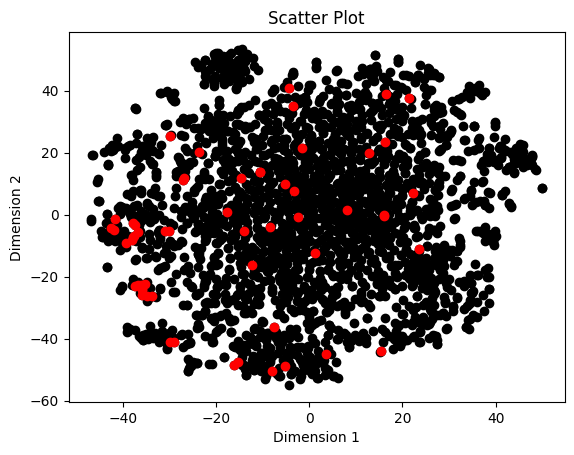

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from pymongo import MongoClient

def load_vectors_from_mongodb(title,unit_type='line'):
    text_id = connection.find('texts',title=title)[0].id
    vectors = pd.DataFrame(connection.aggregate('vectors',[{'$match': {'text': text_id, 'unit_type': unit_type}}, 
                                               {"$project": {"_id": 0, "index": 1, "tags": {"$arrayElemAt": ["$tags", 0]}, "unit_type": 1, "vector": 1}}],
                                              encode=False))
    vectors['title'] = title
    data = np.array([np.array(vector) for vector in vectors['vector']])
    metadata = vectors.T.drop('vector').T
    return data, metadata

def fit_and_transform_pca(data, n_components=50):
    pca = PCA(n_components=n_components)
    return pca.fit_transform(data)

def fit_and_transform_tsne(data, n_components=2):
    tsne = TSNE(n_components=n_components)
    return tsne.fit_transform(data)

def plot_scatter(data, title="Scatter Plot", color = 'k'):
    plt.scatter(data[:, 0], data[:, 1], c = color)
    plt.title(title)
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")


# Load vectors from MongoDB
data, metadata = load_vectors_from_mongodb('ΠΡΟΣ ΘΑΛΑΣΣΙΟΝ',unit_type='phrase')

# Reduce dimensionality using PCA
pca_result = fit_and_transform_pca(data)
pca_result = (pca_result.T/np.linalg.norm(pca_result,axis=1)).T

# Reduce dimensionality using t-SNE
tsne_result = fit_and_transform_tsne(pca_result)

# Plot the scatter plot
plot_scatter(tsne_result, title="t-SNE Scatter Plot")           
plot_scatter(tsne_result[metadata['tags'].str.contains('61.')], color = 'r')
             
plt.show()

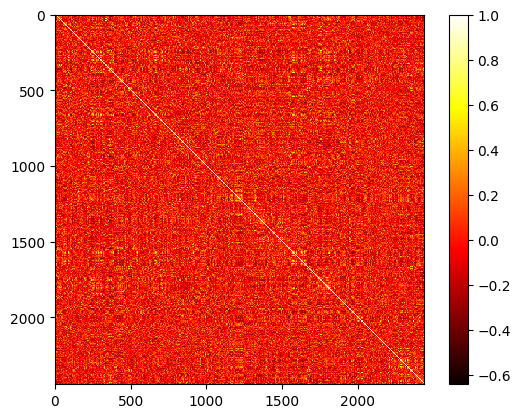

In [18]:
plt.imshow(pca_result.dot(pca_result.T), cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show()

## Compute distances to specific passage

In [19]:
title = 'ΠΡΟΣ ΘΑΛΑΣΣΙΟΝ'
unit_type = 'phrase'
data, metadata = load_vectors_from_mongodb(title,unit_type=unit_type)

pca_result = fit_and_transform_pca(data,n_components=500)
pca_result = (pca_result.T/np.linalg.norm(pca_result,axis=1)).T

title_id = connection.find('texts',title=title)[0].id
content = connection.find('units',tags='58.11',text=title_id,unit_type=unit_type)[0]
content.snippet

'Νοῦς γὰρ καὶ αἴσθησις ἀντικειμένην ἔχουσι πρὸς ἄλληλα τὴν κατὰ φύσιν ἐνέργειαν διὰ τὴν τῶν αὐτοῖς ὑποκειμένων ἀκροτάτην διαφορὰν καὶ ἑτερότητα.'

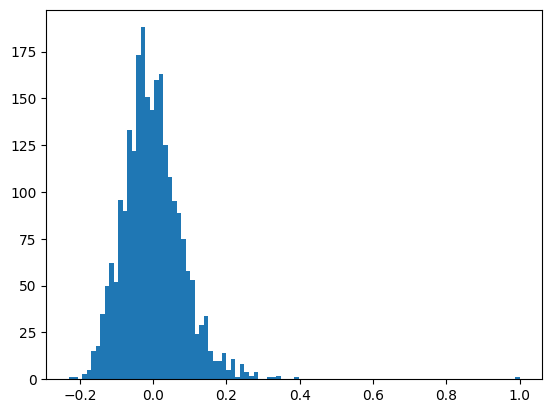

In [20]:
idx = metadata.loc[metadata['index']==content.index].index[0]
metadata['distance'] = pca_result.dot(pca_result[idx,:])
plt.hist(metadata['distance'],bins=100)
plt.show()

In [22]:
N = 15

metadata_sorted = metadata.sort_values('distance',ascending=False)
k = 1
while k <= N:
    idx_k = metadata_sorted['index'].iloc[k]
    tag_k = metadata_sorted['tags'].iloc[k]
    dist_k = metadata_sorted['distance'].iloc[k]
    text_k = connection.find('units',index=idx_k,text=title_id,unit_type=unit_type)[0].snippet

    print(str(k)+'. '+title+' '+tag_k+', distance = '+str(dist_k))
    print(text_k)
    print('-----------------')
    k+=1

1. ΠΡΟΣ ΘΑΛΑΣΣΙΟΝ 44.5, distance = 0.39350131481216705
Ἀμιγὴς γὰρ τῶν ἀντικειμένων ἡ γνῶσις καὶ παντάπασιν ἀσυνύπαρκτος, ἐπείπερ ἡ τοῦδε γνῶσις τὴν θατέρου τῶν ἀντικειμένων συνίστησιν ἄγνοιαν, ὥσπερ οὔτε ὀφθαλμὸς τοῦ ἄνω τε ὁμοῦ καὶ τοῦ κάτω, καὶ τῶν ἐφ᾽ ἑκάτερα κατὰ ταὐτόν, χωρὶς τῆς πρὸς θάτερον ἰδιαζούσης ἐπιστροφῆς καὶ τῶν ἄλλων πάντῃ κεχωρισμένης, ἀντιλαμβάνεσθαι.
-----------------
2. ΠΡΟΣ ΘΑΛΑΣΣΙΟΝ 16.8, distance = 0.34735766076359553
Ἐὰν οὖν τὸ πρὸς ἄλληλα κατὰ σύνθεσιν τέλος τοῦ τε αἰσθητοῦ καὶ τῆς αἰσθήσεως καὶ τῆς ἐπ᾽ αὐτῇ φυσικῆς δυνάμεως θεωρήσας ὁ νοῦς δυνηθῇ πρὸς τὸν οἰκεῖον φύσει λόγον τούτων ἕκαστον διακρίνας ἐπαναγαγεῖν καὶ θεωρῆσαι καθ᾽ ἑαυτὸν τὸ αἰσθητὸν ἄνευ τῆς πρὸς αὐτὸ τῆς αἰσθήσεως σχέσεως καὶ τὴν αἴσθησιν δίχα τῆς τοῦ αἰσθητοῦ πρὸς αὐτὴν οἰκειότητος καὶ τὴν ἐπιθυμίαν, φέρε εἰπεῖν, ἢ ἄλλην τινὰ τῶν κατὰ φύσιν δυνάμεων χωρὶς τῆς ἐμπαθοῦς ἐπ᾽ αἰσθήσει τε καὶ αἰσθητῷ διαθέσεως, ὡς ἡ τοῦ πάθους ποιὰ παρασκευάζει τὴν θεωρίαν γίνεσθαι κίνησις, ἐλέπτυνε λεάνας τοῦ μόσχ